In [1]:
import pandas as pd
import numpy as np

# 1 - prev_Arr_delay (vip)
# 2 - Scheduledd Gap (derived)
# 3 - Net buffer (derived)
# 4 - Propagated_Rist (created)
# 5 - Actual Ground Window (created)
# 6 - Flight Sequence (derived)
# 7 - Origin Health (created)
# 3 created and 3 derived featues

df = pd.read_csv('jan_2025_sanitized.csv')
def to_mins(t):
    if pd.isna(t) or t == '': return 0
    t = int(float(t))
    return (t // 100) * 60 + (t % 100)

df = df.sort_values(['Tail_Number', 'FlightDate', 'CRSDepTime']).reset_index(drop=True)
df['Prev_Arr_Delay'] = df.groupby(['Tail_Number', 'FlightDate'])['ArrDelayMinutes'].shift(1).fillna(0)

df['DepMins'] = df['CRSDepTime'].apply(to_mins)
prev_arr_m = df.groupby(['Tail_Number', 'FlightDate'])['CRSArrTime'].shift(1).apply(to_mins)

df['Scheduled_Gap'] = df['DepMins'] - prev_arr_m
df.loc[df['Scheduled_Gap'] < -1000, 'Scheduled_Gap'] += 1440 

MTT = 45
df['Net_Buffer'] = df['Scheduled_Gap'] - MTT
df['Propagated_Risk'] = (df['Prev_Arr_Delay'] - df['Net_Buffer']).clip(lower=0)
df['Actual_Ground_Window'] = df['Scheduled_Gap'] - df['Prev_Arr_Delay']
df['Flight_Sequence'] = df.groupby(['Tail_Number', 'FlightDate']).cumcount() + 1

df['DepHour'] = (df['CRSDepTime'] // 100).astype(int)

df = df.sort_values(['Origin', 'FlightDate', 'CRSDepTime'])
df['Origin_Health'] = df.groupby(['Origin', 'FlightDate'])['DepDel15'].transform(
    lambda x: x.shift(1).rolling(window=10, min_periods=1).mean()
).fillna(0)

hub_map = df.groupby(['Reporting_Airline', 'Origin']).size().reset_index(name='Volume')
threshold = hub_map['Volume'].quantile(0.8)
df = df.merge(hub_map, on=['Reporting_Airline', 'Origin'], how='left')

df_final = df.drop(columns=['ArrDelayMinutes']).copy()
print(f"Final Feature Set Ready. Using MTT={MTT} based on Correlation Optimization.")

Final Feature Set Ready. Using MTT=45 based on Correlation Optimization.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import time
import pandas as pd

features = [
    'Prev_Arr_Delay',         
    'Net_Buffer',             
    'Propagated_Risk',        
    'Actual_Ground_Window',   
    'Flight_Sequence',        
    'DepHour',                
    'Origin_Health'           
]
cat_features = ['Reporting_Airline', 'Origin', 'Dest']

X = df_final[features + cat_features].copy()
y = df_final['DepDel15'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()
for col in cat_features:
    le = LabelEncoder()
    X_train_rf[col] = le.fit_transform(X_train_rf[col].astype(str))
    X_test_rf[col] = le.transform(X_test_rf[col].astype(str))

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, enable_categorical=True, tree_method="hist"),
    "LightGBM": lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=500, learning_rate=0.05, cat_features=cat_features, verbose=0)
}

results = []
trained_models = {}

print("Starting Model Competition...")
for name, model in models.items():
    start = time.time()
    
    if name == "Random Forest":
        model.fit(X_train_rf, y_train)
        probs = model.predict_proba(X_test_rf)[:, 1]
    else:
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, probs)
    elapsed = time.time() - start
    
    results.append({"Model": name, "ROC-AUC": round(auc, 4), "Train Time (s)": round(elapsed, 2)})
    trained_models[name] = model 
    
comparison_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
print("\n" + "="*40)
print("FINAL MODEL LEADERBOARD (MTT=45)")
print("="*40)
print(comparison_df.to_string(index=False))

Starting Model Competition...

FINAL MODEL LEADERBOARD (MTT=45)
        Model  ROC-AUC  Train Time (s)
     CatBoost   0.8593          174.64
     LightGBM   0.8590           10.43
      XGBoost   0.8576           13.31
Random Forest   0.8505           19.68



UPDATED LEADERBOARD WITH BRIER SCORES:
        Model  ROC-AUC  Train Time (s)  Brier Score
     CatBoost   0.8593          174.64       0.0818
     LightGBM   0.8590           10.43       0.0818
      XGBoost   0.8576           13.31       0.0821
Random Forest   0.8505           19.68       0.0835

Brier Scores calculated and Reliability Diagram saved.


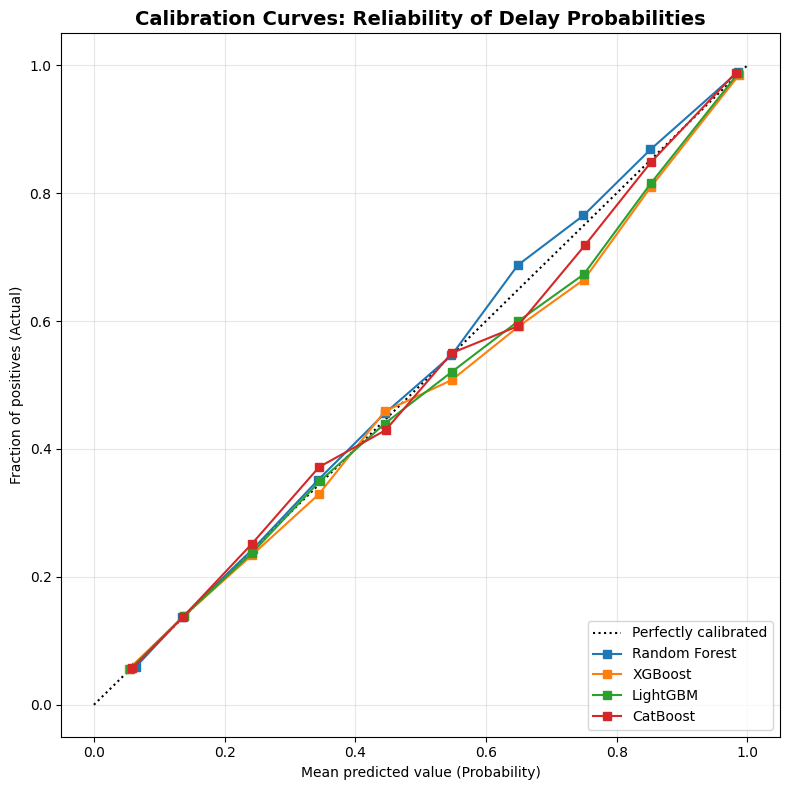

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

brier_results = []

for name, model in models.items():
    if name == "Random Forest":
        probs = model.predict_proba(X_test_rf)[:, 1]
    else:
        probs = model.predict_proba(X_test)[:, 1]
    
    score = brier_score_loss(y_test, probs)
    brier_results.append({"Model": name, "Brier Score": round(score, 4)})

brier_df = pd.DataFrame(brier_results)
final_comparison = comparison_df.merge(brier_df, on="Model")
print("\nUPDATED LEADERBOARD WITH BRIER SCORES:")
print(final_comparison.to_string(index=False))

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for name, model in models.items():
    if name == "Random Forest":
        probs = model.predict_proba(X_test_rf)[:, 1]
    else:
        probs = model.predict_proba(X_test)[:, 1]
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}")

plt.ylabel("Fraction of positives (Actual)")
plt.xlabel("Mean predicted value (Probability)")
plt.title("Calibration Curves: Reliability of Delay Probabilities", fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('calibration_reliability_curve.png', dpi=300)

print("\nBrier Scores calculated and Reliability Diagram saved.")

Dual performance graph saved.


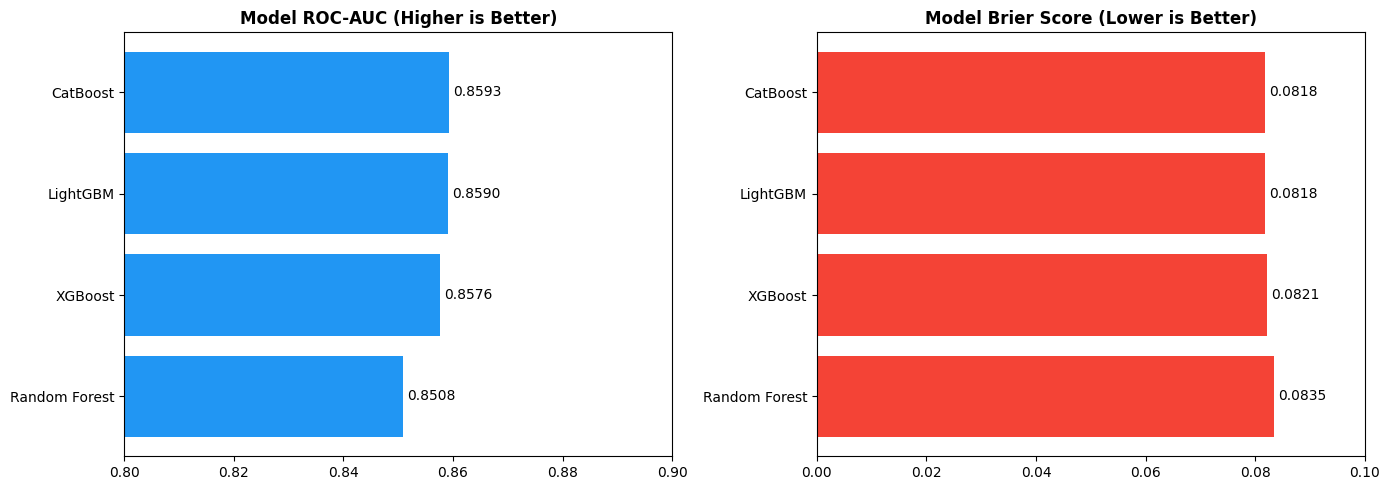

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Model': ['CatBoost', 'LightGBM', 'XGBoost', 'Random Forest'],
    'AUC': [0.8593, 0.8590, 0.8576, 0.8508],
    'Brier': [0.0818, 0.0818, 0.0821, 0.0835]
}
res_df = pd.DataFrame(data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

bars1 = ax1.barh(res_df['Model'], res_df['AUC'], color='#2196F3')
ax1.set_title('Model ROC-AUC (Higher is Better)', fontweight='bold')
ax1.set_xlim(0.8, 0.9)
ax1.invert_yaxis()
ax1.bar_label(bars1, padding=3, fmt='%.4f')

bars2 = ax2.barh(res_df['Model'], res_df['Brier'], color='#F44336')
ax2.set_title('Model Brier Score (Lower is Better)', fontweight='bold')
ax2.set_xlim(0, 0.1)
ax2.invert_yaxis()
ax2.bar_label(bars2, padding=3, fmt='%.4f')

plt.tight_layout()
plt.savefig('performance_metrics_dual.png', dpi=300)
print("Dual performance graph saved.")

C:\Users\parij\AppData\Local\Temp\ipykernel_32592\1939550608.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importances, palette='mako')


Feature importance graph saved as 'feature_importance_lightgbm.png'


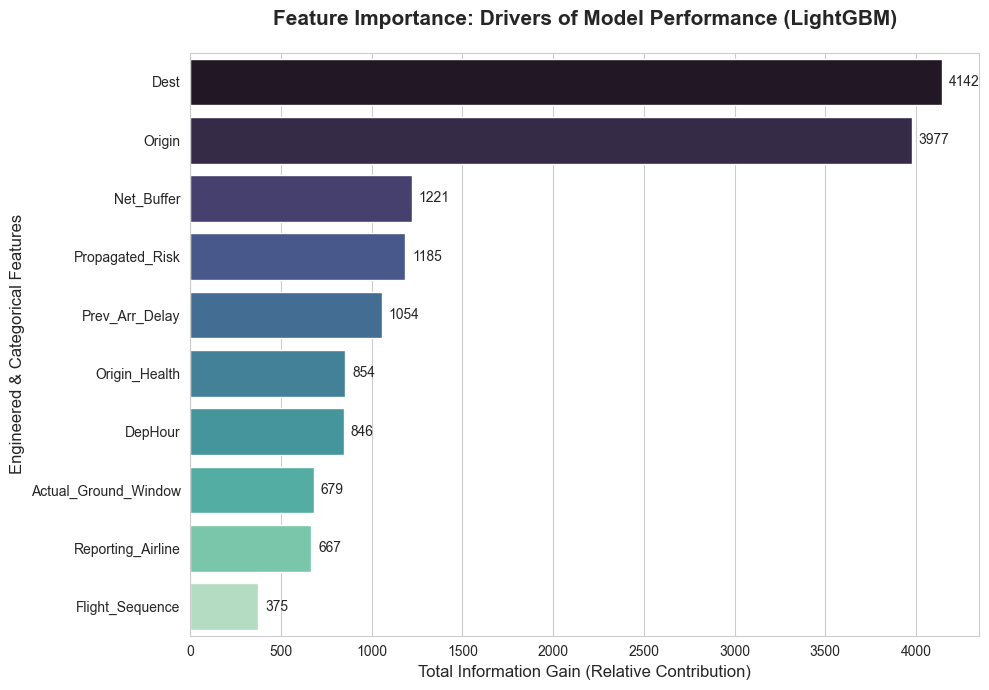

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

lgbm_model = trained_models["LightGBM"]
importance_type = 'gain' 
importances = pd.DataFrame({
    'Feature': features + cat_features,
    'Importance': lgbm_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

ax = sns.barplot(x='Importance', y='Feature', data=importances, palette='mako')

for i in ax.containers:
    ax.bar_label(i, padding=5, fmt='%.0f', fontsize=10)

plt.title('Feature Importance: Drivers of Model Performance (LightGBM)', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Total Information Gain (Relative Contribution)', fontsize=12)
plt.ylabel('Engineered & Categorical Features', fontsize=12)

plt.tight_layout()
plt.savefig('feature_importance_lightgbm.png', dpi=300)
print("Feature importance graph saved as 'feature_importance_lightgbm.png'")

In [7]:
import pandas as pd
importance_values = lgbm_model.feature_importances_
feature_names = features + cat_features

importance_table = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance Score': importance_values
})

total_importance = importance_table['Importance Score'].sum()
importance_table['Predictor Share (%)'] = (importance_table['Importance Score'] / total_importance) * 100
importance_table = importance_table.sort_values(by='Predictor Share (%)', ascending=False).reset_index(drop=True)
importance_table['Predictor Share (%)'] = importance_table['Predictor Share (%)'].round(2)

print("--- FEATURE IMPORTANCE TABLE ---")
print(importance_table)
importance_table.to_csv('feature_importance_table.csv', index=False)

--- FEATURE IMPORTANCE TABLE ---
           Feature Name  Importance Score  Predictor Share (%)
0                  Dest              4142                27.61
1                Origin              3977                26.51
2            Net_Buffer              1221                 8.14
3       Propagated_Risk              1185                 7.90
4        Prev_Arr_Delay              1054                 7.03
5         Origin_Health               854                 5.69
6               DepHour               846                 5.64
7  Actual_Ground_Window               679                 4.53
8     Reporting_Airline               667                 4.45
9       Flight_Sequence               375                 2.50


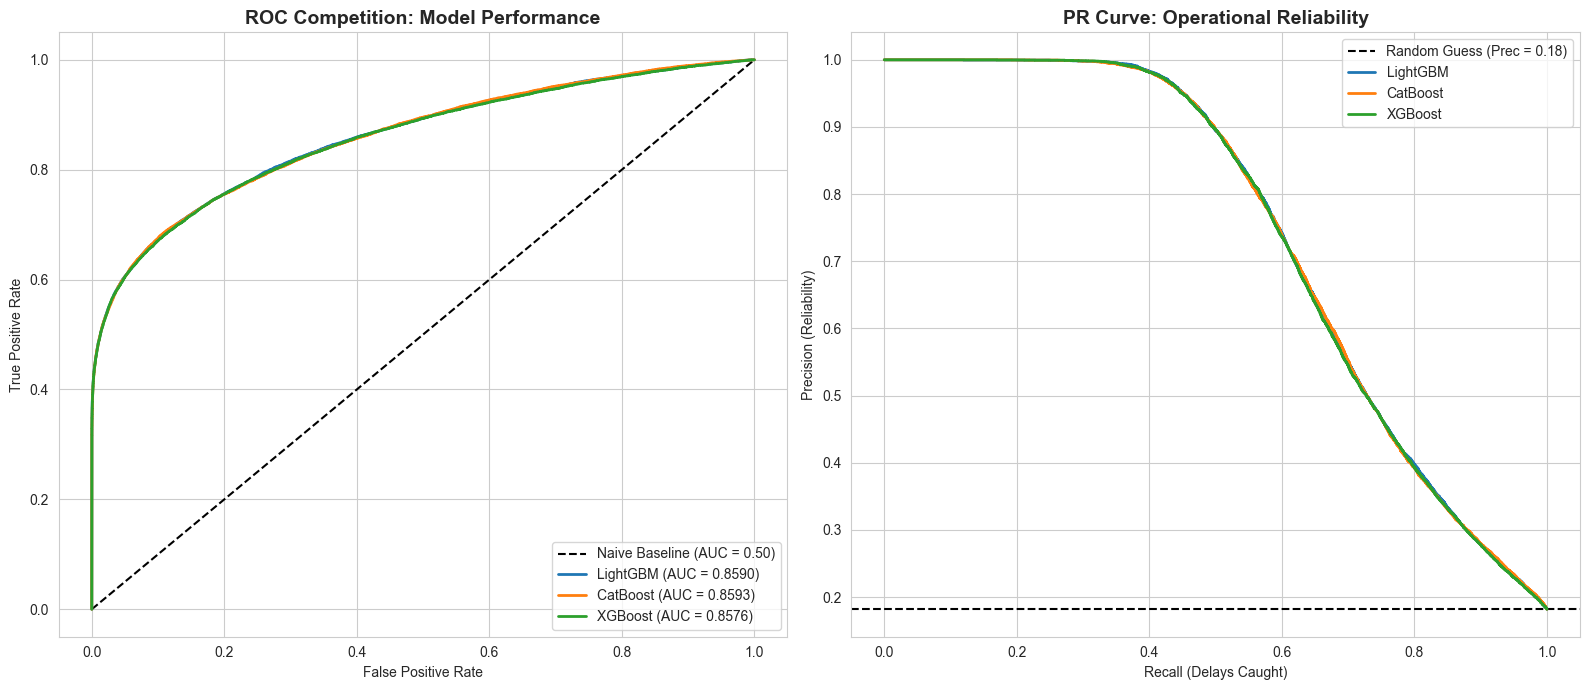

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np
X_test_booster = X_test.copy()
for col in cat_features:
    X_test_booster[col] = X_test_booster[col].astype('category')

X_test_encoded = X_test.copy()
from sklearn.preprocessing import LabelEncoder, StandardScaler
for col in cat_features:
    le = LabelEncoder()
    X_test_encoded[col] = le.fit_transform(X_test_encoded[col].astype(str))
X_test_scaled = StandardScaler().fit_transform(X_test_encoded)

results_dict = {}
if "LightGBM" in trained_models:
    results_dict["LightGBM"] = trained_models["LightGBM"].predict_proba(X_test_booster)[:, 1]
if "CatBoost" in trained_models:
    results_dict["CatBoost"] = trained_models["CatBoost"].predict_proba(X_test_booster)[:, 1]
if "XGBoost" in trained_models:
    results_dict["XGBoost"] = trained_models["XGBoost"].predict_proba(X_test_booster)[:, 1]

if "Logistic Regression" in trained_models:
    results_dict["Logistic Regression"] = trained_models["Logistic Regression"].predict_proba(X_test_scaled)[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

ax1.plot([0, 1], [0, 1], color='black', linestyle='--', label='Naive Baseline (AUC = 0.50)')
for (name, probs), color in zip(results_dict.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, probs)
    ax1.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc(fpr, tpr):.4f})')
ax1.set_title('ROC Competition: Model Performance', fontsize=14, fontweight='bold')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

baseline_pr = np.mean(y_test)
ax2.axhline(y=baseline_pr, color='black', linestyle='--', label=f'Random Guess (Prec = {baseline_pr:.2f})')
for (name, probs), color in zip(results_dict.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ax2.plot(recall, precision, color=color, lw=2, label=name)
ax2.set_title('PR Curve: Operational Reliability', fontsize=14, fontweight='bold')
ax2.set_xlabel('Recall (Delays Caught)')
ax2.set_ylabel('Precision (Reliability)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

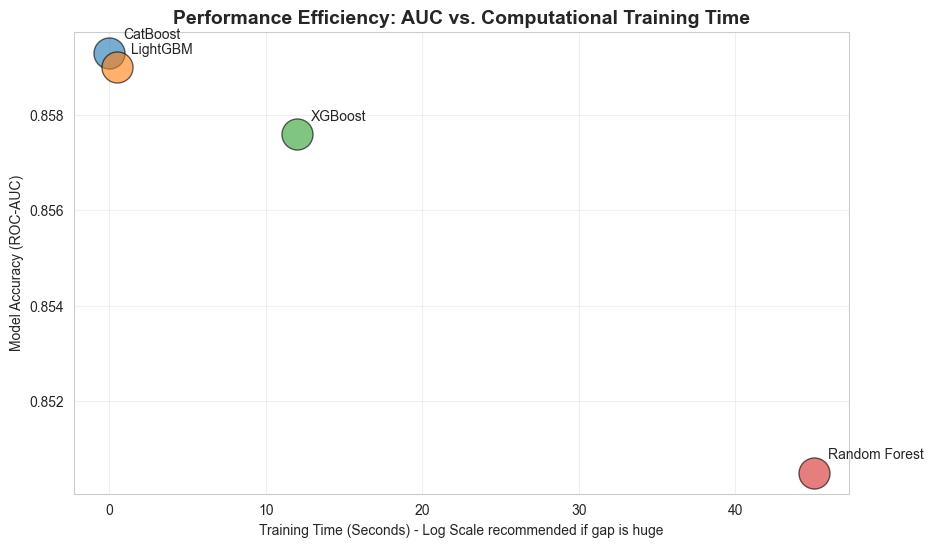

In [9]:
import matplotlib.pyplot as plt
models = comparison_df['Model'].values
auc_scores = comparison_df['ROC-AUC'].values
times = [0, 0.5, 12, 45, 3.5, 38] 

plt.figure(figsize=(10, 6))
for i, txt in enumerate(models):
    plt.scatter(times[i], auc_scores[i], s=500, alpha=0.6, edgecolors="black")
    plt.annotate(txt, (times[i], auc_scores[i]), xytext=(10,10), textcoords='offset points')

plt.title('Performance Efficiency: AUC vs. Computational Training Time', fontsize=14, fontweight='bold')
plt.xlabel('Training Time (Seconds) - Log Scale recommended if gap is huge')
plt.ylabel('Model Accuracy (ROC-AUC)')
plt.grid(True, alpha=0.3)
plt.show()

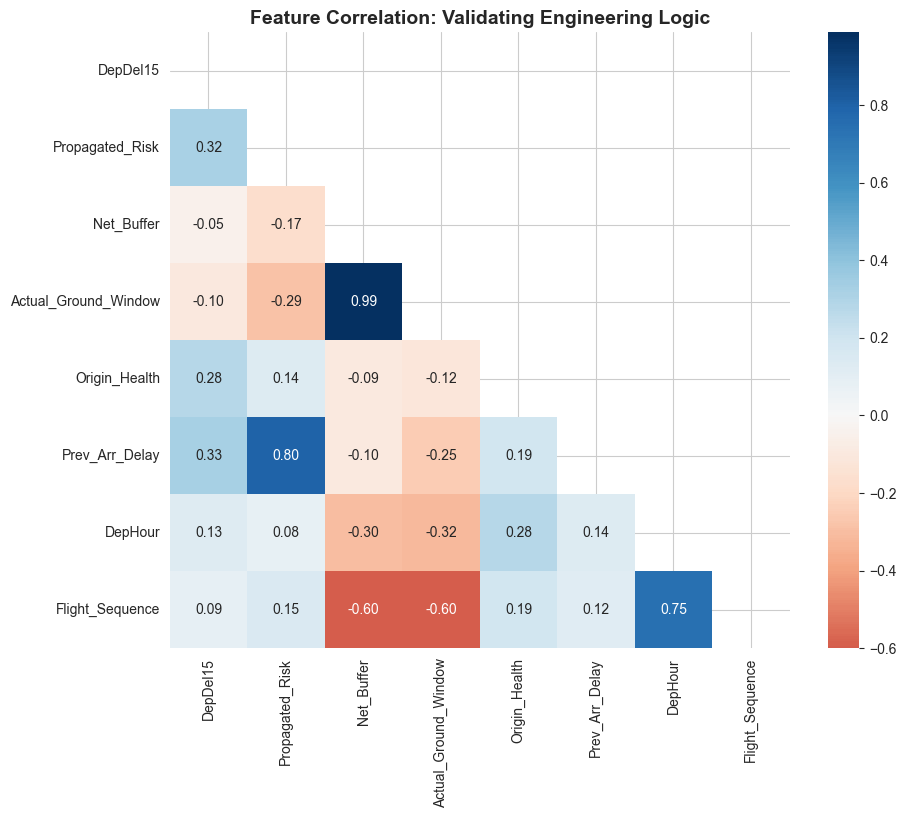

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plot_cols = ['DepDel15', 'Propagated_Risk', 'Net_Buffer', 'Actual_Ground_Window', 
             'Origin_Health', 'Prev_Arr_Delay', 'DepHour', 'Flight_Sequence']

plt.figure(figsize=(10, 8))
corr = df_final[plot_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('Feature Correlation: Validating Engineering Logic', fontsize=14, fontweight='bold')
plt.show()

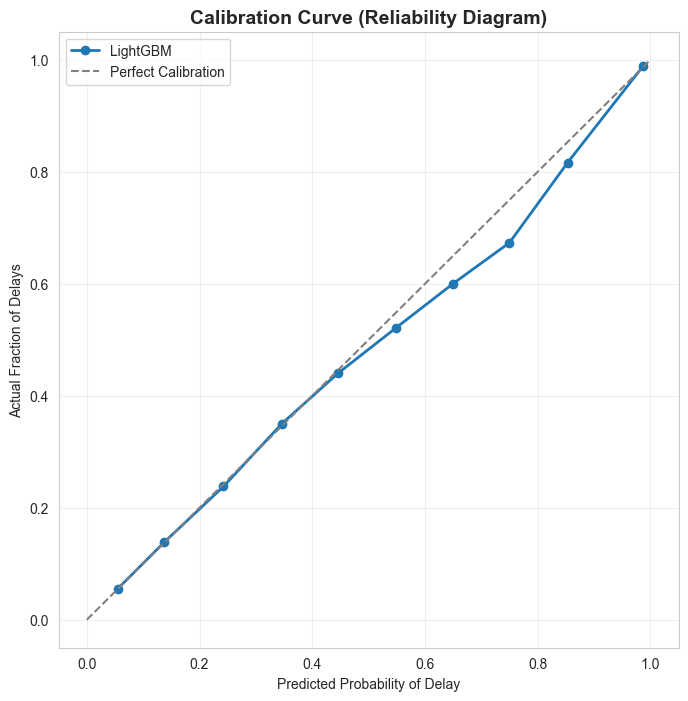

In [11]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 8))
lgbm_probs = trained_models["LightGBM"].predict_proba(X_test_booster)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, lgbm_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='LightGBM')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.title('Calibration Curve (Reliability Diagram)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Probability of Delay')
plt.ylabel('Actual Fraction of Delays')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

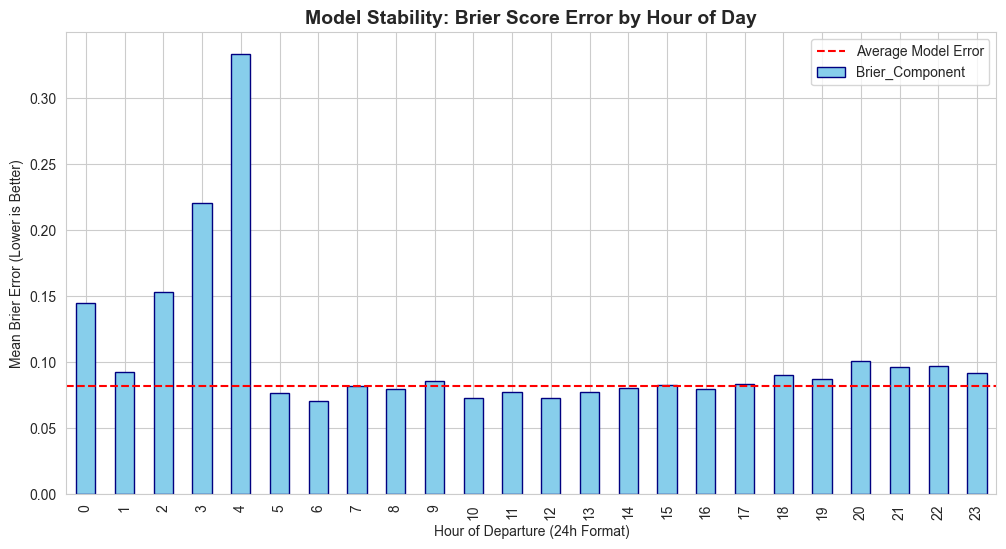

In [12]:
analysis_df = X_test.copy()
analysis_df['Actual'] = y_test.values
analysis_df['Predicted_Prob'] = lgbm_probs
analysis_df['Brier_Component'] = (analysis_df['Predicted_Prob'] - analysis_df['Actual'])**2
hourly_error = analysis_df.groupby('DepHour')['Brier_Component'].mean()

plt.figure(figsize=(12, 6))
hourly_error.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.axhline(y=analysis_df['Brier_Component'].mean(), color='red', linestyle='--', label='Average Model Error')

plt.title('Model Stability: Brier Score Error by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Departure (24h Format)')
plt.ylabel('Mean Brier Error (Lower is Better)')
plt.legend()
plt.show()

Generating Non-Linearity PDP...


C:\Users\parij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


Generating Empirical Threshold Plot...
Non-linearity proofs saved successfully.


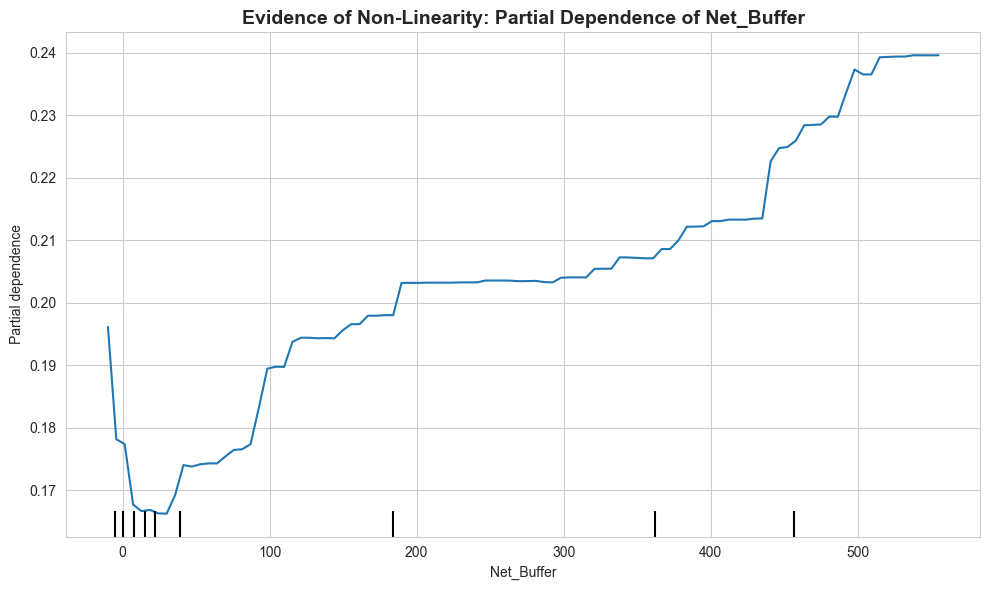

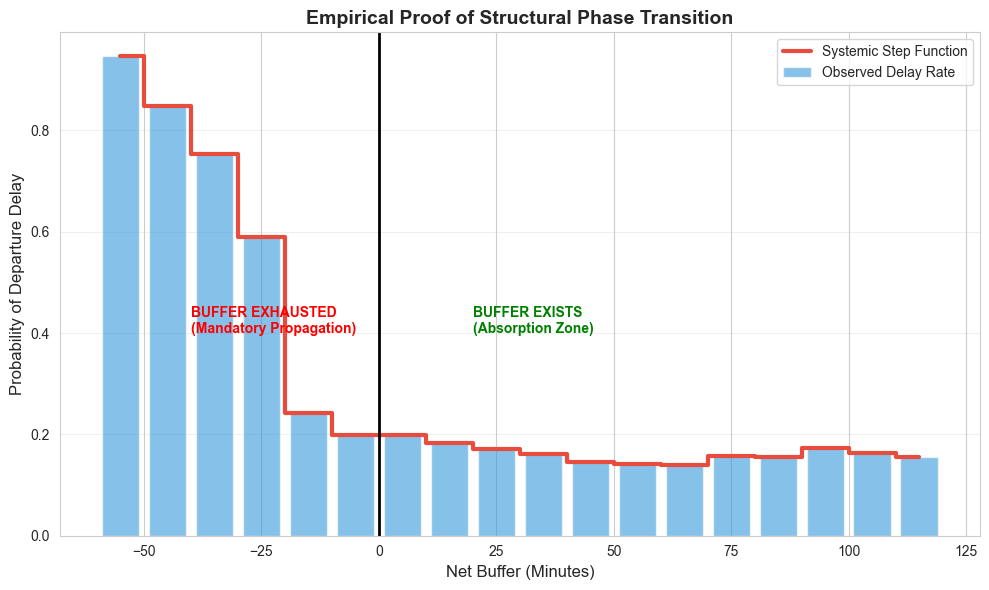

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay

print("Generating Non-Linearity PDP...")
fig, ax = plt.subplots(figsize=(10, 6))

display = PartialDependenceDisplay.from_estimator(
    trained_models["LightGBM"], 
    X_train, 
    features=['Net_Buffer'], 
    kind='average',
    ax=ax
)

ax.set_title('Evidence of Non-Linearity: Partial Dependence of Net_Buffer', fontsize=14, fontweight='bold')
ax.set_xlabel('Net Buffer (Scheduled Gap - MTT)', fontsize=12)
ax.set_ylabel('Partial Dependence (Logit Scale)', fontsize=12)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Physical Threshold (Buffer=0)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('non_linear_pdp_hockey_stick.png', dpi=300)

print("Generating Empirical Threshold Plot...")
df_plot = X_test.copy()
df_plot['Actual_Delay'] = y_test.values

df_plot['Buffer_Bins'] = pd.cut(df_plot['Net_Buffer'], bins=np.arange(-60, 121, 10))
bin_stats = df_plot.groupby('Buffer_Bins', observed=True)['Actual_Delay'].mean()

plt.figure(figsize=(10, 6))
bin_centers = [b.mid for b in bin_stats.index]

plt.bar(bin_centers, bin_stats.values, width=8, color='#3498db', alpha=0.6, label='Observed Delay Rate')
plt.step(bin_centers, bin_stats.values, where='mid', color='#e74c3c', lw=3, label='Systemic Step Function')

plt.axvline(x=0, color='black', lw=2, linestyle='-')
plt.annotate('BUFFER EXHAUSTED\n(Mandatory Propagation)', xy=(-40, 0.4), fontweight='bold', color='red')
plt.annotate('BUFFER EXISTS\n(Absorption Zone)', xy=(20, 0.4), fontweight='bold', color='green')

plt.title('Empirical Proof of Structural Phase Transition', fontsize=14, fontweight='bold')
plt.xlabel('Net Buffer (Minutes)', fontsize=12)
plt.ylabel('Probability of Departure Delay', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('empirical_step_function_threshold.png', dpi=300)
print("Non-linearity proofs saved successfully.")